In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import os

from sklearn.model_selection import train_test_split

**Context**

Kaggle dataset link https://www.kaggle.com/birdy654/scene-classification-images-and-audio

In [244]:
data = pd.read_csv('/kaggle/input/scene-classification-images-and-audio/dataset.csv', delimiter=',', nrows=None)
data_train = np.array(data)

audio = data_train[:,1:-2].astype('float32') #last index of the interval isn't included in the range : CLASS1
labels = data_train[:,-1]
img_paths = data['IMAGE']

classes = ["FOREST", "CLASSROOM", "CITY", "RIVER", "GROCERY-STORE","JUNGLE","BEACH","FOOTBALL-MATCH","RESTAURANT"]
for index,class_name in enumerate(classes):
    labels = np.where(labels == class_name, index, labels)

labels.astype('int32')

data.head(5)

,IMAGE,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_97,mfcc_98,mfcc_99,mfcc_100,mfcc_101,mfcc_102,mfcc_103,mfcc_104,CLASS1,CLASS2
0,images/forest/forest0.png,15.795384,-3.442518,-25.316836,-33.412104,2.447290,-46.981182,12.889984,-23.588534,-22.625879,...,-43.876462,20.697491,-22.793173,-9.417196,13.762870,-31.976786,18.461561,-13.140673,OUTDOORS,FOREST
1,images/forest/forest1.png,15.883880,-3.494075,-21.189490,-18.077115,4.284962,-27.014271,3.666955,-9.091312,-3.746509,...,-33.883092,17.223236,-24.985005,12.035913,8.321000,-16.249293,8.717523,0.743640,OUTDOORS,FOREST
2,images/forest/forest2.png,17.872629,-18.877467,-31.665319,-47.045579,1.813430,-45.899877,14.975982,-24.462396,-1.812962,...,-34.456028,21.433239,-14.190274,-8.629235,1.035640,-20.703358,5.986662,-14.644013,OUTDOORS,FOREST
3,images/forest/forest3.png,16.843997,-3.527753,-21.282970,-24.248141,27.201589,-18.787674,30.093938,-1.922008,10.156418,...,-36.410615,19.949251,-5.466172,6.480569,13.070739,-14.853299,10.243606,-17.983957,OUTDOORS,FOREST
4,images/forest/forest4.png,16.128583,-4.267328,-25.608325,-20.231084,15.922823,-35.703313,16.307644,-3.547505,4.804142,...,-41.548915,15.697646,-20.615005,-11.942869,5.421639,-27.445147,9.060233,-15.077528,OUTDOORS,FOREST


In [222]:
img_train, img_temp, audio_train, audio_temp, labels_train, labels_temp = train_test_split(img_paths, audio, labels, train_size=0.6)
img_val, img_test, audio_val, audio_test, labels_val, labels_test = train_test_split(img_temp, audio_temp, labels_temp, train_size=0.5)

We define the seeds that allows to generate randomly the same numbers, thus making results reproducible

In [223]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)
np.random.seed(0)

**Pytorch Dataset**

We create Dataset class

In [224]:
from torch.utils.data import Dataset
from PIL import Image

class ImgAudioDataset(Dataset):
    def __init__(self, root_dir, img_data, audio_data, labels=None, img_transform=None, audio_transform=None):
        self.root_dir = root_dir
        self.img_data = img_data
        self.audio_data = audio_data
        self.labels = labels
        self.img_transform = img_transform
        self.audio_transform = audio_transform
        
    def __len__(self):
        return len(self.img_data)
        
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.img_data.iloc[idx]))
        audio = self.audio_data[idx,:]
        if self.img_transform:
            img = self.img_transform(img)
        if self.audio_transform:
            audio = self.audio_transform(audio)        
                               
        return ((img, audio) if labels is None else (img, audio, int(self.labels[idx])))

**TRAIN**

In [225]:
import time
import copy
from torch.cuda.amp import autocast, GradScaler

def train(data_type, model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    i = 1
    train_acc_vals = []
    train_loss_vals = []
    val_acc_vals = []
    
    scaler = GradScaler()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        print("epoch : " + str(i))
        i+=1
        
        running_loss = 0.0
        running_corrects = 0.0
        epoch_loss_sum = 0.0
        epoch_loss = 0.0
        epoch_acc = 0.0

        model.train()
        for index, data in enumerate(train_loader):
            img, audio, labels = data
            img, audio, labels = img.cuda(), audio.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            
            with autocast():
                # forward
                if data_type == "img":
                    outputs = model(img)
                elif data_type == "audio":
                    outputs = model(audio)
                elif data_type == "imgaudio":
                    outputs = model(img, audio)
                else:
                    raise ValueError('Data must be img, audio or imgaudio')
                loss = criterion(outputs,labels) # compare obtained and expected output
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels)
                epoch_loss_sum += loss.item()
                
            # scale aim to prevent zero flush of low magnitude gradient values
            scaler.scale(loss).backward() # backward
            scaler.step(optimizer) # compute gradient for optimization
            scaler.update()
            
            #print statistics
            running_loss += loss.item()
            if index % 200 == 199:    
                print('[%d, %5d] loss: %.3f' % (epoch + 1, index + 1, running_loss / 200))
                running_loss = 0.0
                
        best_model = copy.deepcopy(model.state_dict())
                 
        epoch_loss = epoch_loss_sum / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        
        print(f'Epoch accuracy: {epoch_acc}, Epoch loss: {epoch_loss}')
        
        train_loss_vals.append(epoch_acc)
        train_acc_vals.append(epoch_loss)
            
    
        """
            #We compute validation data accuracy on each epoch to prevent overfitting 
            #if val_accuracy isn't improved by current training epoch
            val_acc = 0
            model.eval()
            with torch.no_grad: #Validation data aim to test, not to train NN --> grad isn't needed
                for img, audio, labels in val_loader:
                    img, audio, labels = img.cuda(), audio.cuda(), labels.cuda()
                    if data_type == "img":
                        outputs = model(img)
                    elif data_type == "audio":
                        outputs = model(audio)
                    else:
                        outputs = model(img, audio)
                        """
        print(f'Epoch duration : {time.time() - epoch_start}')
        model.load_state_dict(best_model)
    return model, train_loss_vals, train_acc_vals, val_acc_vals

**PREDICT**

In [226]:
def predict(test_loader, model):
    model.eval()
    
    with torch.no_grad: #Validation data aim to test, not to train NN --> grad isn't needed
        for data_type, img, audio, labels in test_loader:
            img, audio = img.cuda(), audio.cuda()
        if data_type == "img":
            outputs = model(img)
        elif data_type == "audio":
            outputs = model(audio)
        else:
             outputs = model(img, audio)
                
    return None

**<font size="6" color="darkblue">IMAGES</font>**

Explication données image

**IMAGE VISUALIZATION**

**DATA TRANSFORMATION** 

In [227]:
from torchvision import transforms

# DA : Data Augmentation
# DP : Data Preparation --> transform data to a more ergonomic data format

img_train_transform = transforms.Compose([ #Compose is used to chain multiple transforms to create a transformation pipeline
    transforms.RandomResizedCrop(224), #DA
    transforms.RandomHorizontalFlip(), #DA
    transforms.ToTensor(), #DP to compute on GPU
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #DP
])
img_val_transform = transforms.Compose([
    transforms.Resize(256), #DA fixed resize and crop for reliability
    transforms.CenterCrop(224),# DA
    transforms.ToTensor(), #DP
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #DP
])

**IMAGE LOADER**

In [228]:
from torch.utils.data import Dataset, DataLoader

train_data = ImgAudioDataset(root_dir='/kaggle/input/scene-classification-images-and-audio', img_data=img_train, audio_data=audio_train, labels=labels_train, img_transform=img_train_transform)
val_data = ImgAudioDataset(root_dir='/kaggle/input/scene-classification-images-and-audio/', img_data=img_val,  audio_data=audio_val,labels=labels_val, img_transform=img_val_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

**TRANSFER LEARNING** 

We load a pretrained neural network on ImageNet dataset.

In [229]:
import torchvision.models
import torch
import torch.nn as nn
import torch.nn.functional as F

resnext = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)

for param in resnext.parameters():
    param.requires_grad = False
    
num_ftrs = resnext.fc.in_features
resnext.fc = nn.Linear(num_ftrs, 9)

resnext = resnext.cuda()

In [230]:
from torch.optim import lr_scheduler
import torch.optim as optim

optimizer = optim.Adam(resnext.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)

In [231]:
import matplotlib.pyplot as plt

epochs = 10
data_type = 'img'
resnext, loss_vals, train_acc_vals, val_acc_vals = train(data_type, resnext, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

epoch : 1
[1,   200] loss: 0.693
[1,   400] loss: 0.325
[1,   600] loss: 0.262
Epoch accuracy: 0.8791421055793762, Epoch loss: 0.02611831506459958
Epoch duration : 70.44312930107117
epoch : 2
[2,   200] loss: 0.233
[2,   400] loss: 0.217
[2,   600] loss: 0.217
Epoch accuracy: 0.9320838451385498, Epoch loss: 0.013718721404280822
Epoch duration : 69.65638756752014
epoch : 3
[3,   200] loss: 0.200
[3,   400] loss: 0.190
[3,   600] loss: 0.182
Epoch accuracy: 0.9396193623542786, Epoch loss: 0.011769087775653124
Epoch duration : 69.95826888084412
epoch : 4
[4,   200] loss: 0.201
[4,   400] loss: 0.190
[4,   600] loss: 0.179
Epoch accuracy: 0.9363346695899963, Epoch loss: 0.011735761784362227
Epoch duration : 70.77776789665222
epoch : 5
[5,   200] loss: 0.169
[5,   400] loss: 0.179
[5,   600] loss: 0.169
Epoch accuracy: 0.9430972933769226, Epoch loss: 0.01087837010536909
Epoch duration : 69.55069279670715
epoch : 6
[6,   200] loss: 0.165
[6,   400] loss: 0.144
[6,   600] loss: 0.162
Epoch ac

**<font size="6" color="darkblue">AUDIO</font>**

Type de données MCCF

**AUDIO DATA VISUALIZATION**

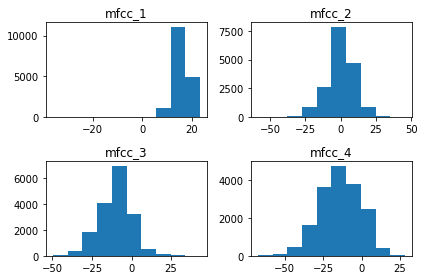

In [232]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.hist(audio[::,0])
plt.title('mfcc_1')
plt.subplot(2,2,2)
plt.hist(audio[::,1])
plt.title('mfcc_2')
plt.subplot(2,2,3)
plt.hist(audio[::,2])
plt.title('mfcc_3')
plt.subplot(2,2,4)
plt.hist(audio[::,3])
plt.title('mfcc_4')
plt.tight_layout()

In [233]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(104, 156)
        self.bn1 = nn.BatchNorm1d(156)
        
        self.linear2 = nn.Linear(156, 208)
        self.bn2 = nn.BatchNorm1d(208)
        
        self.linear3 = nn.Linear(208, 156)
        self.bn3 = nn.BatchNorm1d(156)
        
        self.linear4 = nn.Linear(156, 104)
        self.bn4 = nn.BatchNorm1d(104)
        
        self.linear5 = nn.Linear(104, 64)
        self.bn5 = nn.BatchNorm1d(64)


        self.final = nn.Linear(64,9)
      
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.linear1(x)))
        x = F.leaky_relu(self.bn2(self.linear2(x)))
        x = F.leaky_relu(self.bn3(self.linear3(x)))
        x = F.leaky_relu(self.bn4(self.linear4(x)))
        x = F.leaky_relu(self.bn5(self.linear5(x)))

        x = self.final(x)
        return x

mlp = MLP().cuda()

**DATA PROCESSING METHODS**

In [234]:
def normalize(data):
    return (data - np.mean(data, axis=0))/np.std(data, axis=0)

audio_train = normalize(audio_train)
audio_val = normalize(audio_val)

In [235]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [236]:
class RandomCircularShift:      
    def __call__(self, tensor):
        return torch.roll(tensor, 13*np.random.randint(8),dims=0)

**AUDIO DATA TRANSFORMATION** 

In [247]:
img_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
img_val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

audio_train_transform = transforms.Compose([
    torch.from_numpy,
    AddGaussianNoise(0.0, 0.1),
    RandomCircularShift()
])

audio_val_transform = transforms.Compose([
    torch.from_numpy,
    AddGaussianNoise(0.0, 0.1),
    RandomCircularShift()
])

**AUDIO DATA LOADER**

In [248]:
train_data = ImgAudioDataset(root_dir='/kaggle/input/scene-classification-images-and-audio', 
                                img_data=img_train, audio_data=audio_train, labels=labels_train, img_transform = img_train_transform, audio_transform=audio_train_transform)
val_data = ImgAudioDataset(root_dir='/kaggle/input/scene-classification-images-and-audio4', 
                           img_data=img_val, audio_data=audio_val, labels=labels_val, img_transform = img_val_transform, audio_transform=audio_val_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

In [249]:
optimizer = optim.Adam(resnext.fc.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)

In [250]:
epochs = 10
data_type = 'audio'
mlp, loss_vals, train_acc_vals, val_acc_vals = train(data_type, mlp, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

epoch : 1
[1,   200] loss: 2.258
[1,   400] loss: 2.273
[1,   600] loss: 2.266
Epoch accuracy: 0.12163075804710388, Epoch loss: 0.14148957297924278
Epoch duration : 57.21779203414917
epoch : 2
[2,   200] loss: 2.261
[2,   400] loss: 2.260
[2,   600] loss: 2.269
Epoch accuracy: 0.11911892890930176, Epoch loss: 0.1414788984904576
Epoch duration : 56.88335061073303
epoch : 3
[3,   200] loss: 2.267
[3,   400] loss: 2.261
[3,   600] loss: 2.267
Epoch accuracy: 0.11882910132408142, Epoch loss: 0.1416385346317669
Epoch duration : 57.19689226150513
epoch : 4
[4,   200] loss: 2.279
[4,   400] loss: 2.260
[4,   600] loss: 2.257
Epoch accuracy: 0.11766979098320007, Epoch loss: 0.1415878338302901
Epoch duration : 56.679038286209106
epoch : 5
[5,   200] loss: 2.270
[5,   400] loss: 2.262
[5,   600] loss: 2.268
Epoch accuracy: 0.1201816275715828, Epoch loss: 0.14164912354000617
Epoch duration : 57.190605878829956
epoch : 6
[6,   200] loss: 2.261
[6,   400] loss: 2.256
[6,   600] loss: 2.263
Epoch ac